# useful benchmarks directories
test_all_spec_benchmarks20250920T204859Z

## just one run

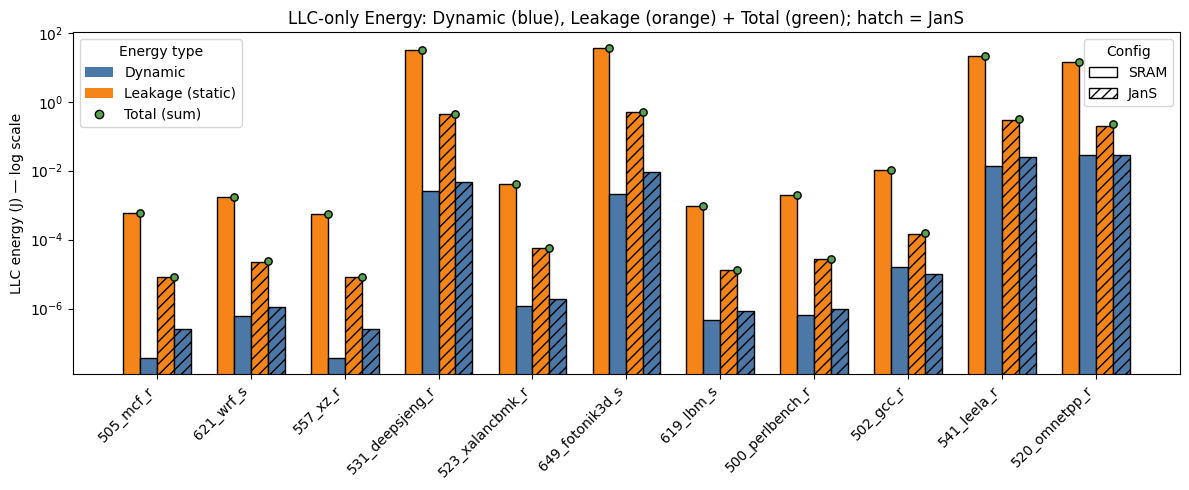

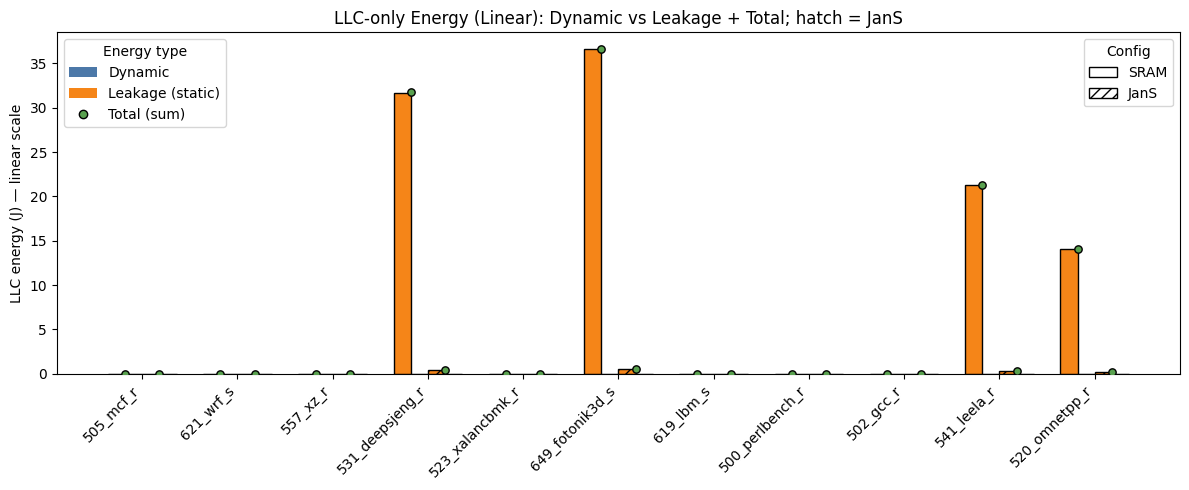

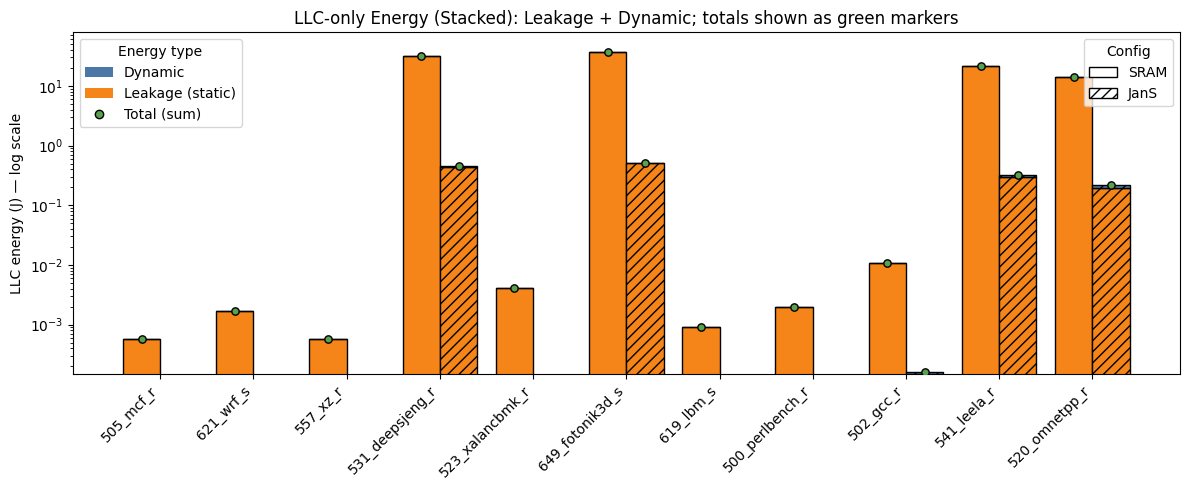

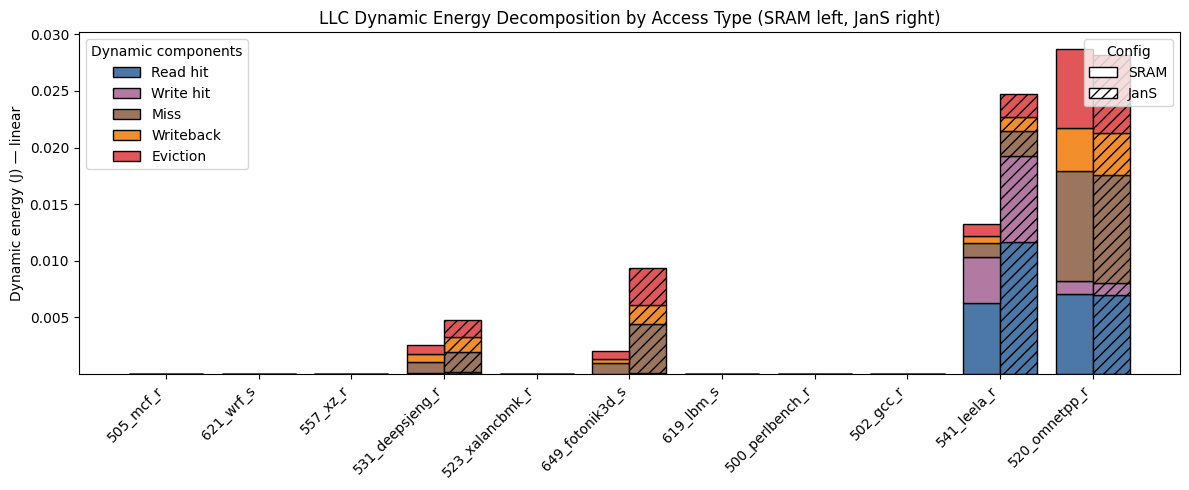

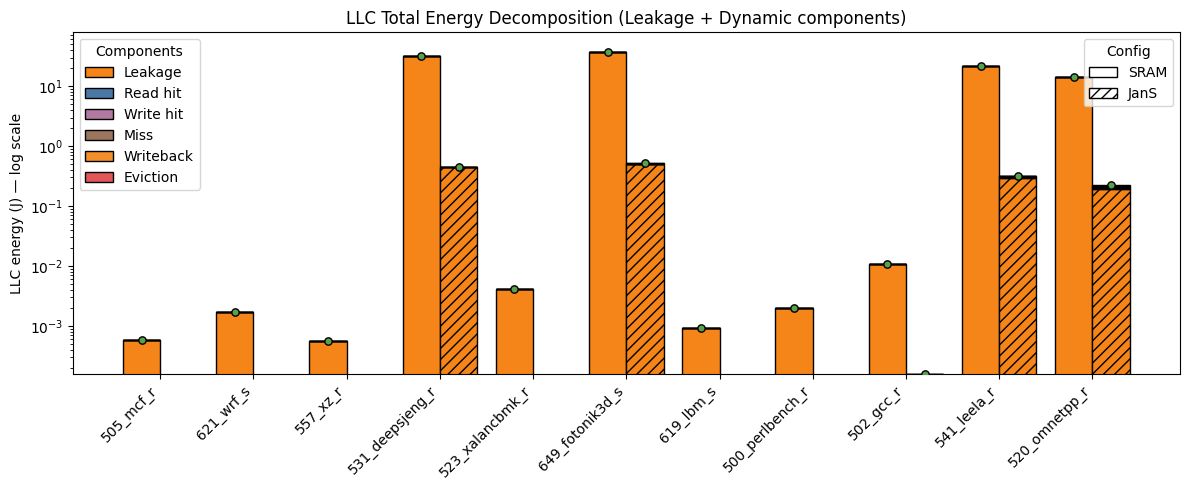

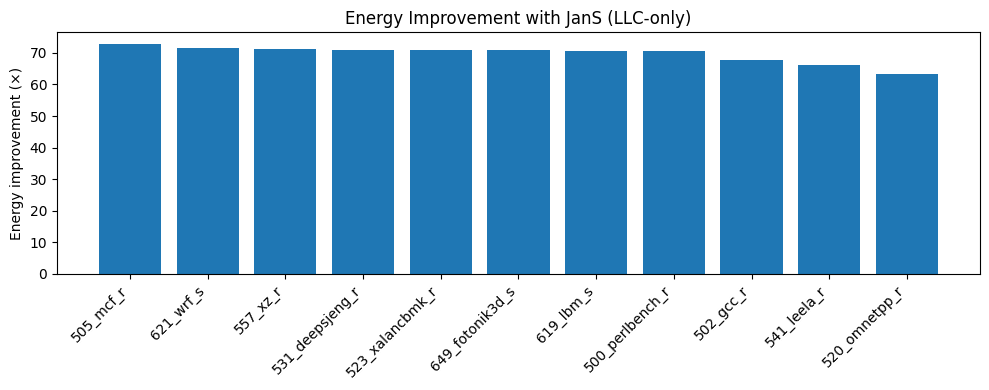

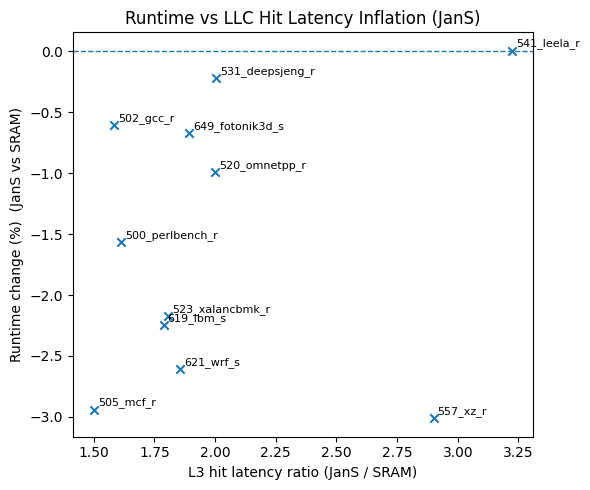

Benchmarks: 11
Median energy improvement (×): 70.80461464168437
Median runtime delta (%): -1.5679442508710806
Median hit-latency ratio: 1.8556488513345428
SRAM dynamic shares (weighted):
  Read hit  : 0.288
  Write hit : 0.111
  Miss      : 0.277
  Writeback : 0.118
  Eviction  : 0.206
JanS dynamic shares (weighted):
  Read hit  : 0.280
  Write hit : 0.130
  Miss      : 0.268
  Writeback : 0.118
  Eviction  : 0.204


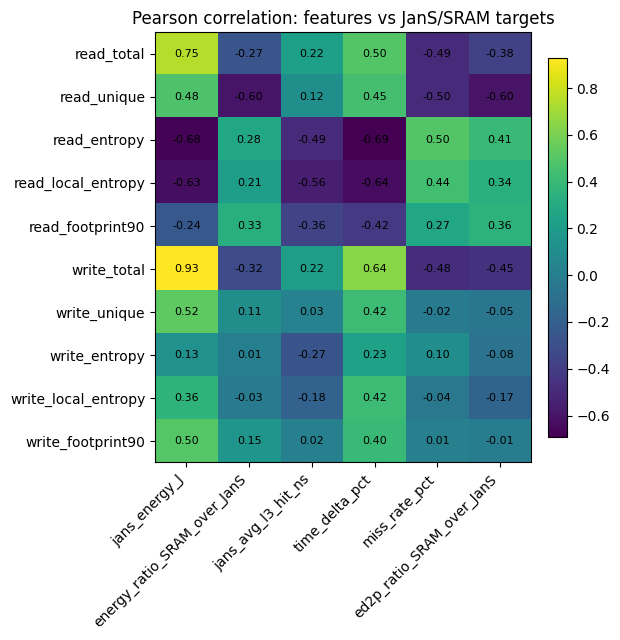

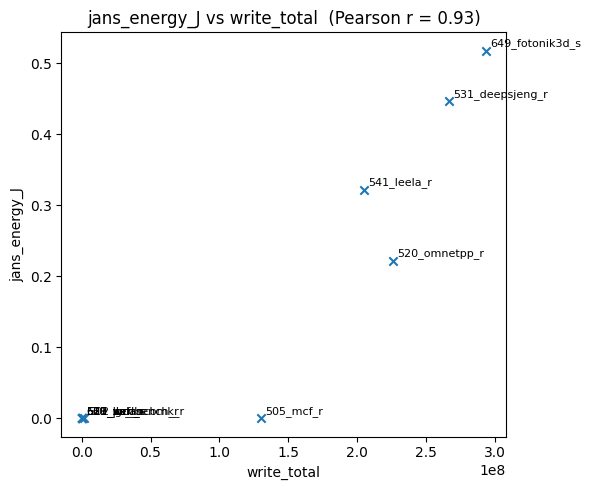

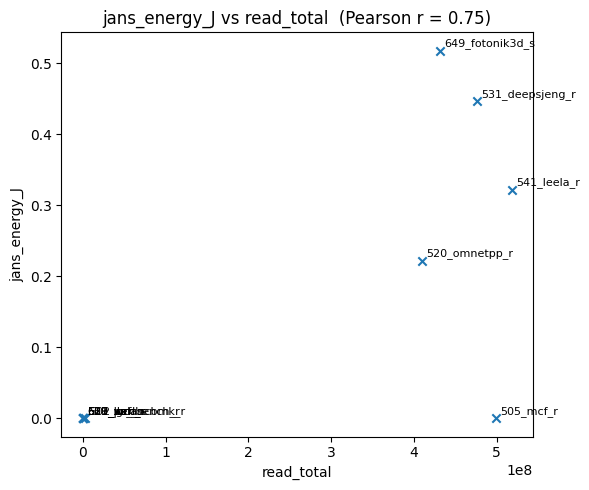

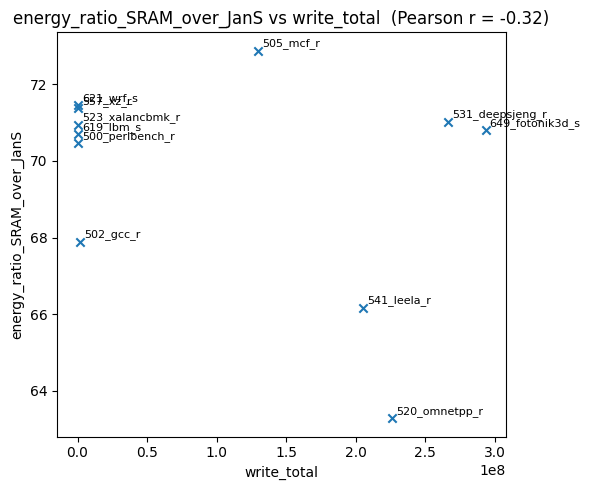

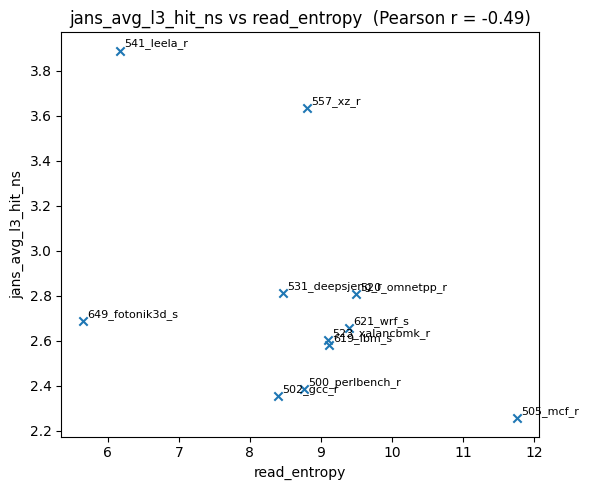

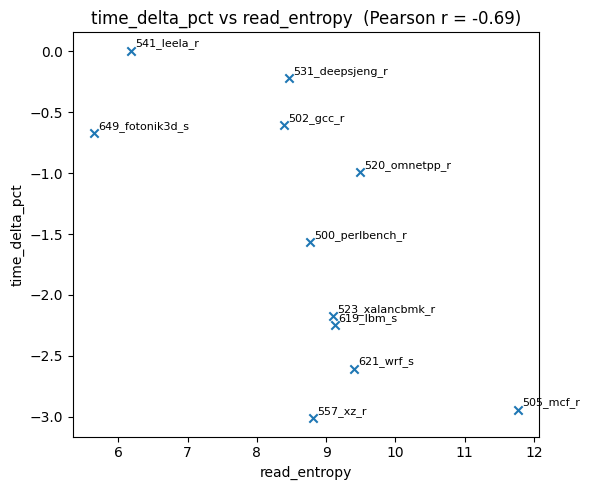

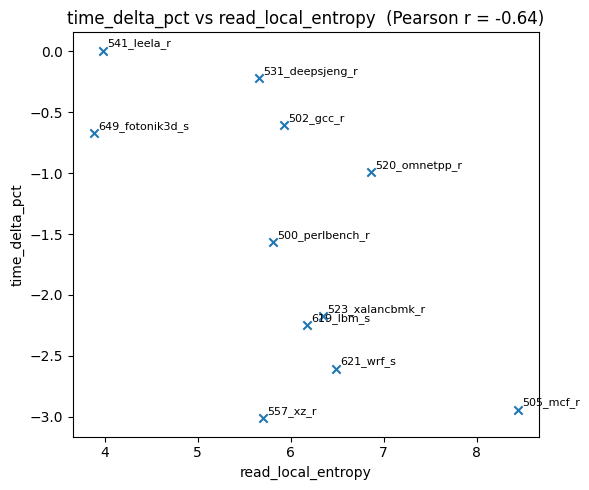

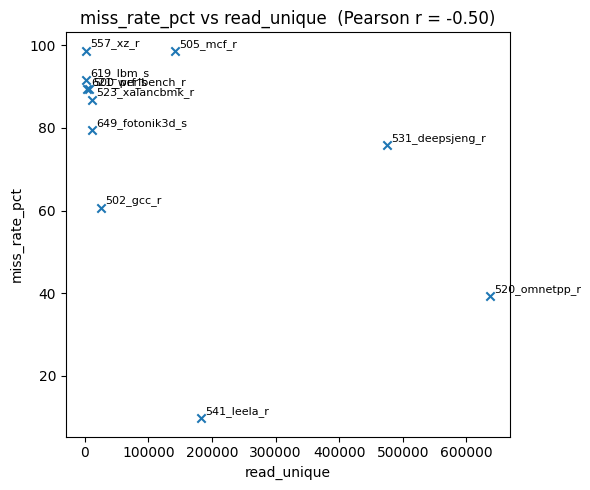

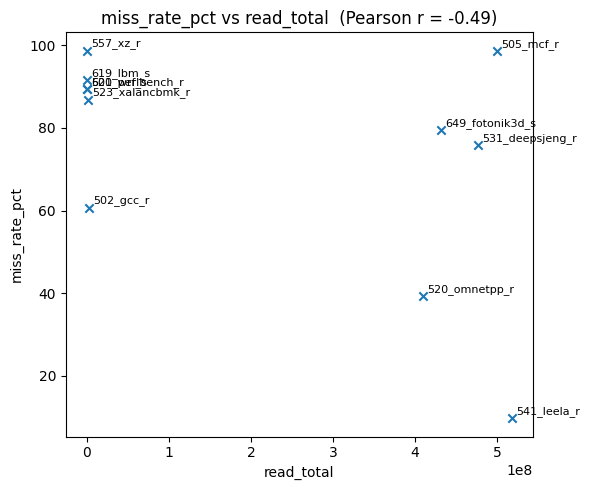

Merged benches: 11
Targets summary (median):
  jans_energy_J: 5.8e-05
  energy_ratio_SRAM_over_JanS: 70.80461464168437
  jans_avg_l3_hit_ns: 2.65553
  time_delta_pct: -1.5679442508710806
  miss_rate_pct: 86.81
  ed2p_ratio_SRAM_over_JanS: 71.94726836769905


In [13]:
import os, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- knobs ----------
# Weighted apportioning of dynamic energy across event types.
# Change these if you believe (e.g.) MRAM writes cost more than reads dynamically.
DECOMP_WEIGHTS = {
    "read_hit": 1.0,
    "write_hit": 1.0,
    "miss": 1.0,
    "writeback": 1.0,
    "eviction": 1.0,
}

RUN_ID  = "test_all_spec_benchmarks20250920T204859Z"
RUN_ID = "test_all_spec_benchmarks_iso8m_20250921T153104Z"
RUN_DIR = f"/home/skataoka26/COSC_498/miniMXE/results/{RUN_ID}"
FEATURES_CSV = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_test_20250922T224013Z.csv"  # using the test one
FEATURES_CSV = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_test_20250925T035958Z.csv"
FEATURES_CSV = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_combined.csv"

# ---------- load ----------
energy_files = sorted(glob.glob(os.path.join(RUN_DIR, "output_*", "energy_bounds.csv")))
if not energy_files:
    raise SystemExit(f"No energy_bounds.csv found under {RUN_DIR}")
dfE = pd.concat([pd.read_csv(f) for f in energy_files], ignore_index=True)

# ---------- normalize ----------
for col in [
    "time_s", "energy_exact_J", "ed2p_exact_J_s2",
    "leak_W", "leak_J", "dyn_exact_nJ",
    "l3_accesses","l3_misses_db","l3_read_hits","l3_write_hits","l3_writebacks","l3_evictions"
]:
    if col in dfE.columns:
        dfE[col] = pd.to_numeric(dfE[col], errors="coerce")

# Dynamic Joules
dfE["dyn_exact_J"] = np.where(dfE["dyn_exact_nJ"].notna(), dfE["dyn_exact_nJ"] * 1e-9, np.nan)
# Fallbacks
mask_leak = dfE["leak_J"].isna() & dfE["leak_W"].notna() & dfE["time_s"].notna()
dfE.loc[mask_leak, "leak_J"] = dfE.loc[mask_leak, "leak_W"] * dfE.loc[mask_leak, "time_s"]
mask_dyn  = dfE["dyn_exact_J"].isna() & dfE["energy_exact_J"].notna() & dfE["leak_J"].notna()
dfE.loc[mask_dyn, "dyn_exact_J"] = (dfE.loc[mask_dyn, "energy_exact_J"] - dfE.loc[mask_dyn, "leak_J"]).clip(lower=0)

# ---------- pivot (include counts so we can decompose) ----------
E_piv = dfE.pivot_table(
    index="benchmark", columns="config",
    values=[
        "time_s", "energy_exact_J", "ed2p_exact_J_s2", "leak_J", "dyn_exact_J",
        "l3_read_hits","l3_write_hits","l3_misses_db","l3_writebacks","l3_evictions"
    ],
    aggfunc="first"
)

def pick_epiv(col, cfg):
    return E_piv[(col, cfg)] if (col, cfg) in E_piv.columns else pd.Series(dtype=float)

benchmarks = E_piv.index.tolist()
sram_E    = pick_epiv("energy_exact_J", "SRAM")
jans_E    = pick_epiv("energy_exact_J", "JanS")
sram_T    = pick_epiv("time_s", "SRAM")
jans_T    = pick_epiv("time_s", "JanS")
sram_ED2P = pick_epiv("ed2p_exact_J_s2", "SRAM")
jans_ED2P = pick_epiv("ed2p_exact_J_s2", "JanS")
sram_leak = pick_epiv("leak_J", "SRAM")
jans_leak = pick_epiv("leak_J", "JanS")
sram_dyn  = pick_epiv("dyn_exact_J", "SRAM").clip(lower=0)
jans_dyn  = pick_epiv("dyn_exact_J", "JanS").clip(lower=0)

# event counts (fillna 0 to be safe)
sram_RH = pick_epiv("l3_read_hits",  "SRAM").fillna(0)
jans_RH = pick_epiv("l3_read_hits",  "JanS").fillna(0)
sram_WH = pick_epiv("l3_write_hits", "SRAM").fillna(0)
jans_WH = pick_epiv("l3_write_hits", "JanS").fillna(0)
sram_M  = pick_epiv("l3_misses_db",  "SRAM").fillna(0)
jans_M  = pick_epiv("l3_misses_db",  "JanS").fillna(0)
sram_WB = pick_epiv("l3_writebacks", "SRAM").fillna(0)
jans_WB = pick_epiv("l3_writebacks", "JanS").fillna(0)
sram_EV = pick_epiv("l3_evictions",  "SRAM").fillna(0)
jans_EV = pick_epiv("l3_evictions",  "JanS").fillna(0)

# ---------- summary.csv bits ----------
summary_files = sorted(glob.glob(os.path.join(RUN_DIR, "output_*", "summary.csv")))
if not summary_files:
    raise SystemExit(f"[ERR] No summary.csv found under {RUN_DIR}")
dfS = pd.concat([pd.read_csv(f) for f in summary_files], ignore_index=True)
if "avg_l3_hit_ns" in dfS.columns:
    dfS["avg_l3_hit_ns"] = pd.to_numeric(dfS["avg_l3_hit_ns"], errors="coerce")
if "l3_miss_rate_pct" in dfS.columns:
    dfS["l3_miss_rate_pct"] = pd.to_numeric(dfS["l3_miss_rate_pct"], errors="coerce")

S_piv = dfS.pivot_table(index="benchmark", columns="config", values="avg_l3_hit_ns", aggfunc="first")
sram_hit_ns = S_piv["SRAM"] if "SRAM" in S_piv.columns else pd.Series(index=benchmarks, dtype=float)
jans_hit_ns = S_piv["JanS"] if "JanS" in S_piv.columns else pd.Series(index=benchmarks, dtype=float)

# ---------- merge for plotting ----------
df = pd.DataFrame({
    "benchmark": benchmarks,
    "sram_energy_J": sram_E.values,
    "jans_energy_J": jans_E.values,
    "sram_time_s":   sram_T.values,
    "jans_time_s":   jans_T.values,
    "sram_avg_l3_hit_ns": sram_hit_ns.reindex(benchmarks).values,
    "jans_avg_l3_hit_ns": jans_hit_ns.reindex(benchmarks).values,
    "sram_ed2p": sram_ED2P.values,
    "jans_ed2p": jans_ED2P.values,

    # components
    "sram_leak_J": sram_leak.values,
    "jans_leak_J": jans_leak.values,
    "sram_dyn_J":  sram_dyn.values,
    "jans_dyn_J":  jans_dyn.values,

    # event counts (for decomposition)
    "sram_RH": sram_RH.values, "jans_RH": jans_RH.values,
    "sram_WH": sram_WH.values, "jans_WH": jans_WH.values,
    "sram_M":  sram_M.values,  "jans_M":  jans_M.values,
    "sram_WB": sram_WB.values, "jans_WB": jans_WB.values,
    "sram_EV": sram_EV.values, "jans_EV": jans_EV.values,
}).dropna(subset=["sram_energy_J","jans_energy_J","sram_time_s","jans_time_s"])

df["energy_ratio_SRAM_over_JanS"] = df["sram_energy_J"] / df["jans_energy_J"]
df["time_delta_pct"] = 100.0 * (df["jans_time_s"] - df["sram_time_s"]) / df["sram_time_s"]
df["hit_ns_ratio_JanS_over_SRAM"] = df["jans_avg_l3_hit_ns"] / df["sram_avg_l3_hit_ns"]
df["ed2p_ratio_SRAM_over_JanS"] = df["sram_ed2p"] / df["jans_ed2p"]

# Order by energy improvement
df_sorted = df.sort_values("energy_ratio_SRAM_over_JanS", ascending=False).reset_index(drop=True)

# ---------- colors ----------
COL_DYNAMIC = "#4C78A8"
COL_LEAK    = "#F58518"
COL_TOTAL   = "#59A14F"

# Category colors for dynamic decomposition
COL_RH = "#4C78A8"   # read hit (blue)
COL_WH = "#B279A2"   # write hit (purple)
COL_M  = "#9C755F"   # miss (brown)
COL_WB = "#F28E2B"   # writeback (orange)
COL_EV = "#E15759"   # eviction (red)

# =========================================================
# PLOT 1: bars (dynamic/leak) + total markers (LOG)
# =========================================================
plt.figure(figsize=(12,5))
x = np.arange(len(df_sorted))
w = 0.18

plt.bar(x - 1.5*w, df_sorted["sram_leak_J"], width=w, color=COL_LEAK,    hatch="",     edgecolor="black")
plt.bar(x - 0.5*w, df_sorted["sram_dyn_J"],  width=w, color=COL_DYNAMIC, hatch="",     edgecolor="black")
plt.bar(x + 0.5*w, df_sorted["jans_leak_J"], width=w, color=COL_LEAK,    hatch="///",  edgecolor="black")
plt.bar(x + 1.5*w, df_sorted["jans_dyn_J"],  width=w, color=COL_DYNAMIC, hatch="///",  edgecolor="black")

sram_center = x - w
jans_center = x + w
plt.scatter(sram_center, df_sorted["sram_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.scatter(jans_center, df_sorted["jans_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)

plt.yscale("log")
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("LLC energy (J) — log scale")
plt.title("LLC-only Energy: Dynamic (blue), Leakage (orange) + Total (green); hatch = JanS")
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_energy = [
    Patch(facecolor=COL_DYNAMIC, label="Dynamic"),
    Patch(facecolor=COL_LEAK,    label="Leakage (static)"),
    Line2D([0],[0], marker="o", linestyle="None", markeredgecolor="black",
           markerfacecolor=COL_TOTAL, label="Total (sum)")
]
leg1 = plt.legend(handles=legend_energy, loc="upper left", title="Energy type")
plt.gca().add_artist(leg1)
plt.legend(handles=[
    Patch(facecolor="white", edgecolor="black", hatch="",    label="SRAM"),
    Patch(facecolor="white", edgecolor="black", hatch="///", label="JanS"),
], loc="upper right", title="Config")
plt.tight_layout(); plt.show()

# =========================================================
# PLOT 2: same bars + totals (LINEAR)
# =========================================================
plt.figure(figsize=(12,5))
plt.bar(x - 1.5*w, df_sorted["sram_leak_J"], width=w, color=COL_LEAK,    hatch="",     edgecolor="black")
plt.bar(x - 0.5*w, df_sorted["sram_dyn_J"],  width=w, color=COL_DYNAMIC, hatch="",     edgecolor="black")
plt.bar(x + 0.5*w, df_sorted["jans_leak_J"], width=w, color=COL_LEAK,    hatch="///",  edgecolor="black")
plt.bar(x + 1.5*w, df_sorted["jans_dyn_J"],  width=w, color=COL_DYNAMIC, hatch="///",  edgecolor="black")
plt.scatter(sram_center, df_sorted["sram_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.scatter(jans_center, df_sorted["jans_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("LLC energy (J) — linear scale")
plt.title("LLC-only Energy (Linear): Dynamic vs Leakage + Total; hatch = JanS")
leg1 = plt.legend(handles=legend_energy, loc="upper left", title="Energy type")
plt.gca().add_artist(leg1)
plt.legend(handles=[
    Patch(facecolor="white", edgecolor="black", hatch="",    label="SRAM"),
    Patch(facecolor="white", edgecolor="black", hatch="///", label="JanS"),
], loc="upper right", title="Config")
plt.tight_layout(); plt.show()

# =========================================================
# PLOT 3: stacked (leak + dyn) per config (LOG) + totals
# =========================================================
plt.figure(figsize=(12,5))
width = 0.4
sram_leak_sorted = df_sorted["sram_leak_J"].values
sram_dyn_sorted  = df_sorted["sram_dyn_J"].values
jans_leak_sorted = df_sorted["jans_leak_J"].values
jans_dyn_sorted  = df_sorted["jans_dyn_J"].values
plt.bar(x - width/2, sram_leak_sorted, width, color=COL_LEAK,    hatch="",    edgecolor="black")
plt.bar(x - width/2, sram_dyn_sorted,  width, bottom=sram_leak_sorted, color=COL_DYNAMIC, hatch="", edgecolor="black")
plt.bar(x + width/2, jans_leak_sorted, width, color=COL_LEAK,    hatch="///", edgecolor="black")
plt.bar(x + width/2, jans_dyn_sorted,  width, bottom=jans_leak_sorted, color=COL_DYNAMIC, hatch="///", edgecolor="black")
plt.scatter(x - width/2, df_sorted["sram_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.scatter(x + width/2, df_sorted["jans_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.yscale("log")
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("LLC energy (J) — log scale")
plt.title("LLC-only Energy (Stacked): Leakage + Dynamic; totals shown as green markers")
stack_leg1 = plt.legend(handles=legend_energy, loc="upper left", title="Energy type")
plt.gca().add_artist(stack_leg1)
plt.legend(handles=[
    Patch(facecolor="white", edgecolor="black", hatch="",    label="SRAM"),
    Patch(facecolor="white", edgecolor="black", hatch="///", label="JanS"),
], loc="upper right", title="Config")
plt.tight_layout(); plt.show()

# =========================================================
# PLOT 4 (NEW): Dynamic-only decomposition by access type (LINEAR)
# =========================================================
def split_dynamic(dynJ, RH, WH, M, WB, EV, weights):
    # vectorized split of dynJ across categories by weighted counts
    W = np.array([weights["read_hit"], weights["write_hit"], weights["miss"], weights["writeback"], weights["eviction"]], dtype=float)
    C = np.vstack([RH, WH, M, WB, EV]).T  # shape [N,5]
    Cw = C * W[None, :]
    denom = Cw.sum(axis=1)
    denom = np.where(denom <= 0, 1.0, denom)
    shares = Cw / denom[:, None]
    return shares * dynJ[:, None]  # [N,5]

cats = ["Read hit","Write hit","Miss","Writeback","Eviction"]
cat_cols = [COL_RH, COL_WH, COL_M, COL_WB, COL_EV]

# values in sorted order
s_dyn = df_sorted["sram_dyn_J"].to_numpy()
j_dyn = df_sorted["jans_dyn_J"].to_numpy()
s_C = split_dynamic(
    s_dyn,
    df_sorted["sram_RH"].to_numpy(),
    df_sorted["sram_WH"].to_numpy(),
    df_sorted["sram_M"].to_numpy(),
    df_sorted["sram_WB"].to_numpy(),
    df_sorted["sram_EV"].to_numpy(),
    DECOMP_WEIGHTS
)
j_C = split_dynamic(
    j_dyn,
    df_sorted["jans_RH"].to_numpy(),
    df_sorted["jans_WH"].to_numpy(),
    df_sorted["jans_M"].to_numpy(),
    df_sorted["jans_WB"].to_numpy(),
    df_sorted["jans_EV"].to_numpy(),
    DECOMP_WEIGHTS
)

plt.figure(figsize=(12,5))
width = 0.4
bottom_s = np.zeros(len(df_sorted))
bottom_j = np.zeros(len(df_sorted))
for k, (label, col) in enumerate(zip(cats, cat_cols)):
    plt.bar(x - width/2, s_C[:,k], width, bottom=bottom_s, color=col, edgecolor="black", label=label if k==0 else None)
    plt.bar(x + width/2, j_C[:,k], width, bottom=bottom_j, color=col, edgecolor="black", hatch="///")
    bottom_s += s_C[:,k]
    bottom_j += j_C[:,k]
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("Dynamic energy (J) — linear")
plt.title("LLC Dynamic Energy Decomposition by Access Type (SRAM left, JanS right)")
# Legend: categories (color) + config (hatch)
cat_handles = [Patch(facecolor=c, edgecolor="black", label=lab) for lab, c in zip(cats, cat_cols)]
legA = plt.legend(handles=cat_handles, loc="upper left", title="Dynamic components")
plt.gca().add_artist(legA)
plt.legend(handles=[
    Patch(facecolor="white", edgecolor="black", hatch="",    label="SRAM"),
    Patch(facecolor="white", edgecolor="black", hatch="///", label="JanS"),
], loc="upper right", title="Config")
plt.tight_layout(); plt.show()

# =========================================================
# PLOT 5 (NEW): Total energy decomposition (leakage + dynamic categories) (LOG)
# =========================================================
plt.figure(figsize=(12,5))
width = 0.4
# Start with leakage
plt.bar(x - width/2, df_sorted["sram_leak_J"], width, color=COL_LEAK, edgecolor="black", label="Leakage")
plt.bar(x + width/2, df_sorted["jans_leak_J"], width, color=COL_LEAK, edgecolor="black", hatch="///")
# Stack dynamic categories on top
bottom_s = df_sorted["sram_leak_J"].to_numpy().copy()
bottom_j = df_sorted["jans_leak_J"].to_numpy().copy()
for k, (label, col) in enumerate(zip(cats, cat_cols)):
    plt.bar(x - width/2, s_C[:,k], width, bottom=bottom_s, color=col, edgecolor="black",
            label=label if k==0 else None)
    plt.bar(x + width/2, j_C[:,k], width, bottom=bottom_j, color=col, edgecolor="black", hatch="///")
    bottom_s += s_C[:,k]; bottom_j += j_C[:,k]
# Totals as markers
plt.scatter(x - width/2, df_sorted["sram_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.scatter(x + width/2, df_sorted["jans_energy_J"], marker="o", s=28, color=COL_TOTAL, edgecolor="black", zorder=4)
plt.yscale("log")
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("LLC energy (J) — log scale")
plt.title("LLC Total Energy Decomposition (Leakage + Dynamic components)")
# Legends
comp_handles = [Patch(facecolor=COL_LEAK, edgecolor="black", label="Leakage")] + \
               [Patch(facecolor=c, edgecolor="black", label=lab) for lab, c in zip(cats, cat_cols)]
legB = plt.legend(handles=comp_handles, loc="upper left", title="Components")
plt.gca().add_artist(legB)
plt.legend(handles=[
    Patch(facecolor="white", edgecolor="black", hatch="",    label="SRAM"),
    Patch(facecolor="white", edgecolor="black", hatch="///", label="JanS"),
], loc="upper right", title="Config")
plt.tight_layout(); plt.show()

# =========================================================
# Original improvement & scatter
# =========================================================
plt.figure(figsize=(10,4))
x = np.arange(len(df_sorted))
plt.bar(x, df_sorted["energy_ratio_SRAM_over_JanS"])
plt.xticks(x, df_sorted["benchmark"], rotation=45, ha="right")
plt.ylabel("Energy improvement (×)")
plt.title("Energy Improvement with JanS (LLC-only)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
xr = df["hit_ns_ratio_JanS_over_SRAM"].values
yr = df["time_delta_pct"].values
plt.scatter(xr, yr, marker="x")
for i, row in df.iterrows():
    if not (np.isnan(row["hit_ns_ratio_JanS_over_SRAM"]) or np.isnan(row["time_delta_pct"])):
        plt.annotate(row["benchmark"], (row["hit_ns_ratio_JanS_over_SRAM"], row["time_delta_pct"]),
                     fontsize=8, xytext=(3,3), textcoords="offset points")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("L3 hit latency ratio (JanS / SRAM)")
plt.ylabel("Runtime change (%)  (JanS vs SRAM)")
plt.title("Runtime vs LLC Hit Latency Inflation (JanS)")
plt.tight_layout(); plt.show()

print("Benchmarks:", len(df_sorted))
print("Median energy improvement (×):", df["energy_ratio_SRAM_over_JanS"].median())
print("Median runtime delta (%):", df["time_delta_pct"].median())
print("Median hit-latency ratio:", df["hit_ns_ratio_JanS_over_SRAM"].median())

# ========== quick dynamic shares summary (using your chosen weights) ==========
def share_summary(C_mat, dyn_vec, label):
    totals = C_mat.sum(axis=0)
    share = totals / max(dyn_vec.sum(), 1e-30)
    print(f"{label} dynamic shares (weighted):")
    for lab, s in zip(cats, share):
        print(f"  {lab:10s}: {s:.3f}")
share_summary(s_C, s_dyn, "SRAM")
share_summary(j_C, j_dyn, "JanS")

# =======================================================================
# DONT LOOK AT THIS (unchanged below)
# =======================================================================
def to_float(x):
    try:
        return float(str(x).strip())
    except Exception:
        return np.nan

def bench_key_from_features(name):
    return str(name).replace(".", "_")

def bench_key_from_energy(name):
    return str(name)

feat = pd.read_csv(FEATURES_CSV)
feat["bench"] = feat["name"].map(bench_key_from_features)

feature_cols = [
    "read_total","read_unique","read_entropy","read_local_entropy","read_footprint90",
    "write_total","write_unique","write_entropy","write_local_entropy","write_footprint90",
]
for c in feature_cols:
    feat[c] = pd.to_numeric(feat[c], errors="coerce")

feat_small = feat[["bench"] + feature_cols].drop_duplicates()
dfE["bench"] = dfE["benchmark"].map(bench_key_from_energy)

E = dfE.pivot_table(index="bench", columns="config",
                    values=["time_s","energy_exact_J","ed2p_exact_J_s2"], aggfunc="first")

dfS["bench"] = dfS["benchmark"].map(bench_key_from_energy)
S_hit = dfS.pivot_table(index="bench", columns="config", values="avg_l3_hit_ns", aggfunc="first")
S_miss = dfS.pivot_table(index="bench", columns="config", values="l3_miss_rate_pct", aggfunc="first")

def pick(frame, tup):
    return frame[tup] if tup in frame.columns else pd.Series(dtype=float)

bench_index = sorted(set(E.index) | set(S_hit.index) | set(S_miss.index) | set(feat_small["bench"]))
df2 = pd.DataFrame({"bench": bench_index}).set_index("bench")

df2["sram_energy_J"] = pick(E, ("energy_exact_J","SRAM")).reindex(bench_index)
df2["jans_energy_J"] = pick(E, ("energy_exact_J","JanS")).reindex(bench_index)
df2["sram_time_s"]   = pick(E, ("time_s","SRAM")).reindex(bench_index)
df2["jans_time_s"]   = pick(E, ("time_s","JanS")).reindex(bench_index)
df2["sram_ed2p"]     = pick(E, ("ed2p_exact_J_s2","SRAM")).reindex(bench_index)
df2["jans_ed2p"]     = pick(E, ("ed2p_exact_J_s2","JanS")).reindex(bench_index)

df2["sram_avg_l3_hit_ns"] = S_hit.get("SRAM", pd.Series(dtype=float)).reindex(bench_index)
df2["jans_avg_l3_hit_ns"] = S_hit.get("JanS", pd.Series(dtype=float)).reindex(bench_index)

miss_SRAM = S_miss.get("SRAM", pd.Series(dtype=float)).reindex(bench_index)
miss_JanS = S_miss.get("JanS", pd.Series(dtype=float)).reindex(bench_index)
df2["miss_rate_pct"] = miss_JanS.fillna(miss_SRAM)
df2["energy_ratio_SRAM_over_JanS"] = df2["sram_energy_J"] / df2["jans_energy_J"]
df2["ed2p_ratio_SRAM_over_JanS"]   = df2["sram_ed2p"] / df2["jans_ed2p"]
df2["time_delta_pct"] = 100.0 * (df2["jans_time_s"] - df2["sram_time_s"]) / df2["sram_time_s"]
df2["hit_ns_ratio_JanS_over_SRAM"] = df2["jans_avg_l3_hit_ns"] / df2["sram_avg_l3_hit_ns"]

df2 = df2.merge(feat_small.set_index("bench"), left_index=True, right_index=True, how="inner").dropna()

targets = [
    "jans_energy_J",
    "energy_ratio_SRAM_over_JanS",
    "jans_avg_l3_hit_ns",
    "time_delta_pct",
    "miss_rate_pct",
    "ed2p_ratio_SRAM_over_JanS",
]
num_df = df2[feature_cols + targets].apply(pd.to_numeric, errors="coerce").dropna()
corr = num_df[feature_cols + targets].corr(method="pearson")

C = corr.loc[feature_cols, targets].values
row_labels = feature_cols
col_labels = targets

plt.figure(figsize=(1.5 + 0.8*len(col_labels), 1.5 + 0.5*len(row_labels)))
im = plt.imshow(C, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=45, ha="right")
plt.yticks(np.arange(len(row_labels)), row_labels)
plt.title("Pearson correlation: features vs JanS/SRAM targets")
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        val = C[i, j]
        if not (np.isnan(val) or np.isinf(val)):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()

def top_pairs_for(target, k=3):
    s = corr[target].loc[feature_cols].abs().sort_values(ascending=False)
    return [(fname, float(corr[target].loc[fname])) for fname in s.index[:k]]

for targ in ["jans_energy_J", "energy_ratio_SRAM_over_JanS",
             "jans_avg_l3_hit_ns", "time_delta_pct", "miss_rate_pct"]:
    pairs = top_pairs_for(targ, k=3)
    for fname, r in pairs:
        x = df2[fname].values
        y = df2[targ].values
        plt.figure(figsize=(6,5))
        plt.scatter(x, y, marker="x")
        for bn, xv, yv in zip(df2.index, x, y):
            if not (np.isnan(xv) or np.isnan(yv)):
                plt.annotate(bn, (xv, yv), fontsize=8, xytext=(3,3), textcoords="offset points")
        plt.xlabel(fname)
        plt.ylabel(targ)
        plt.title(f"{targ} vs {fname}  (Pearson r = {r:.2f})")
        plt.tight_layout(); plt.show()

print("Merged benches:", len(df2))
print("Targets summary (median):")
for t in ["jans_energy_J","energy_ratio_SRAM_over_JanS","jans_avg_l3_hit_ns","time_delta_pct","miss_rate_pct","ed2p_ratio_SRAM_over_JanS"]:
    med = df2[t].median()
    print(f"  {t}: {med}")



=== Sanity: leakage modeling ===
SRAM: leak_J ≈ 3.438000 * time_s + -0.000000, R^2=1.000000,  max|leak_J - leak_W*time_s|=1.870e-06 J
JanS: leak_J ≈ 0.048000 * time_s + 0.000000, R^2=1.000000,  max|leak_J - leak_W*time_s|=4.720e-07 J


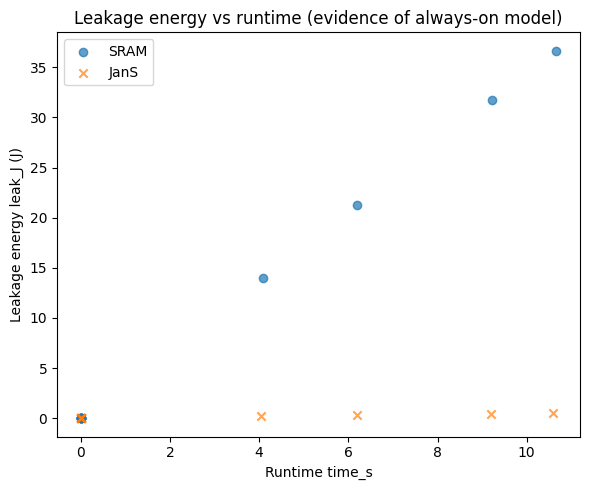


=== Gating opportunity summary — SRAM (N_BANKS=16) ===
median(lambda_bank) = 1.192e+06 /s   median(time_s) = 0.001 s
  T=   0.1 us  median P(gap>T)=8.876e-01  median Exp[#gaps>T]=977.93  median E_save_upper=0.004 J
  T=     1 us  median P(gap>T)=3.036e-01  median Exp[#gaps>T]=437.66  median E_save_upper=0.002 J
  T=     5 us  median P(gap>T)=2.581e-03  median Exp[#gaps>T]=3.36  median E_save_upper=0.000 J
  T=    10 us  median P(gap>T)=6.662e-06  median Exp[#gaps>T]=0.01  median E_save_upper=0.000 J
  T=    50 us  median P(gap>T)=1.312e-26  median Exp[#gaps>T]=0.00  median E_save_upper=0.000 J
  T=   100 us  median P(gap>T)=1.722e-52  median Exp[#gaps>T]=0.00  median E_save_upper=0.000 J
  T=   500 us  median P(gap>T)=1.512e-259  median Exp[#gaps>T]=0.00  median E_save_upper=0.000 J
  T=  1000 us  median P(gap>T)=0.000e+00  median Exp[#gaps>T]=0.00  median E_save_upper=0.000 J
  T=  5000 us  median P(gap>T)=0.000e+00  median Exp[#gaps>T]=0.00  median E_save_upper=0.000 J

=== Gating o

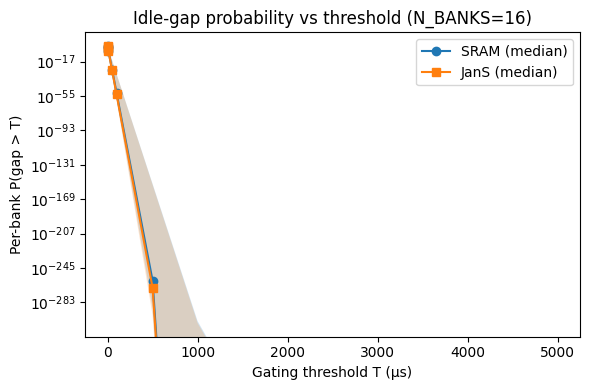

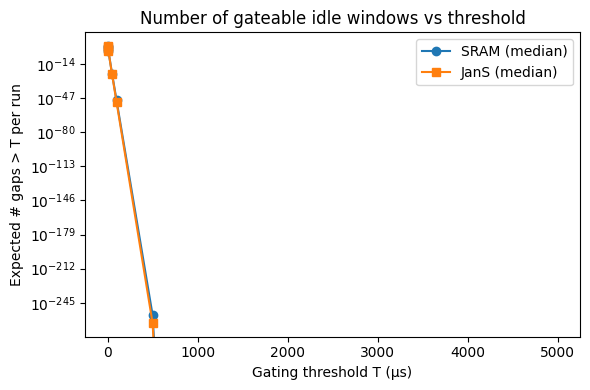

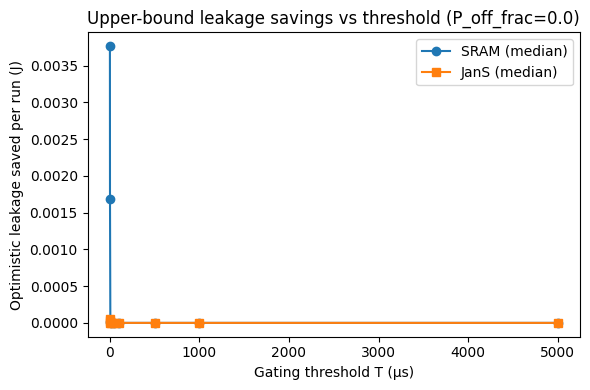

In [8]:
# ============================
# GATING OPPORTUNITY ANALYSIS
# (append after your existing code; uses dfE/df/df_sorted already defined)
# ============================

# ---- knobs (tune these) ----
N_BANKS = 16                    # assumed # of independent SRAM banks/ways for gating
THRESHOLDS_US = [0.1, 1, 5, 10, 50, 100, 500, 1000, 5000]
P_OFF_FRAC = 0.0                # fraction of leak that remains when gated (0=power-gated, >0 drowsy)
E_ENTRY_J  = 0.0                # entry energy overhead per bank-event (J)
E_EXIT_J   = 0.0                # exit  energy overhead per bank-event (J)

# ---- 0) quick sanity: leak_J ≈ leak_W * time_s (=> no gating modeled) ----
chk = dfE.copy()
for c in ["leak_W","leak_J","time_s","config"]:
    chk[c] = pd.to_numeric(chk[c], errors="coerce") if c != "config" else chk[c]

def _fit_leak(df, cfg):
    s = df[df["config"]==cfg].dropna(subset=["leak_W","leak_J","time_s"])
    if len(s)==0:
        print(f"{cfg}: no rows"); return
    X = s["time_s"].to_numpy()
    y = s["leak_J"].to_numpy()
    m = (X@y)/(X@X)  # least-squares slope (near-zero intercept)
    b = y.mean() - m*X.mean()
    r2 = 1 - np.sum((y-(m*X+b))**2)/np.sum((y-y.mean())**2)
    print(f"{cfg}: leak_J ≈ {m:.6f} * time_s + {b:.6f}, R^2={r2:.6f},  max|leak_J - leak_W*time_s|={np.max(np.abs(s['leak_J']-s['leak_W']*s['time_s'])):.3e} J")

print("\n=== Sanity: leakage modeling ===")
_fit_leak(chk, "SRAM")
_fit_leak(chk, "JanS")

plt.figure(figsize=(6,5))
for cfg, marker in [("SRAM","o"), ("JanS","x")]:
    s = chk[chk["config"]==cfg].dropna(subset=["time_s","leak_J"])
    if len(s):
        plt.scatter(s["time_s"], s["leak_J"], alpha=0.7, label=cfg, marker=marker)
plt.xlabel("Runtime time_s")
plt.ylabel("Leakage energy leak_J (J)")
plt.title("Leakage energy vs runtime (evidence of always-on model)")
plt.legend(); plt.tight_layout(); plt.show()

# ---- 1) per-bank Poisson bound for gating opportunity ----
def compute_gating_metrics(dfE, cfg, n_banks=N_BANKS, thresholds_us=THRESHOLDS_US, p_off_frac=P_OFF_FRAC):
    sub = dfE[dfE["config"]==cfg].copy()
    for c in ["l3_accesses","time_s","leak_W","leak_J"]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    sub = sub.dropna(subset=["l3_accesses","time_s","leak_W"])
    sub["rate_total"]  = sub["l3_accesses"] / sub["time_s"]              # requests/s across LLC
    sub["lambda_bank"] = sub["rate_total"] / float(n_banks)              # per-bank rate
    sub["E_leak_total"] = sub["leak_W"] * sub["time_s"]                  # total SRAM leak energy
    for T in thresholds_us:
        T_s = T * 1e-6
        p_gap = np.exp(-sub["lambda_bank"] * T_s)                         # P(gap > T) per bank
        sub[f"p_gap_{T}us"] = p_gap
        sub[f"exp_gaps_{T}us"] = sub["time_s"] * sub["lambda_bank"] * p_gap
        sub[f"frac_time_gated_upper_{T}us"] = p_gap                       # upper-bound time fraction gated
        sub[f"E_save_upper_{T}us"] = sub["E_leak_total"] * p_gap * (1 - p_off_frac)  # optimistic J saved
    return sub

G_SRAM = compute_gating_metrics(dfE, "SRAM")
G_JANS = compute_gating_metrics(dfE, "JanS")

def print_gating_summary(G, label):
    if G is None or G.empty:
        print(f"\n{label}: no rows"); return
    print(f"\n=== Gating opportunity summary — {label} (N_BANKS={N_BANKS}) ===")
    print(f"median(lambda_bank) = {float(G['lambda_bank'].median()):.3e} /s   median(time_s) = {float(G['time_s'].median()):.3f} s")
    for T in THRESHOLDS_US:
        print(f"  T={T:>6} us  "
              f"median P(gap>T)={float(G[f'p_gap_{T}us'].median()):.3e}  "
              f"median Exp[#gaps>T]={float(G[f'exp_gaps_{T}us'].median()):.2f}  "
              f"median E_save_upper={float(G[f'E_save_upper_{T}us'].median()):.3f} J")

print_gating_summary(G_SRAM, "SRAM")
print_gating_summary(G_JANS, "JanS")

# ---- 2) break-even threshold (formula) ----
def print_break_even(G, label, e_entry=E_ENTRY_J, e_exit=E_EXIT_J, p_off_frac=P_OFF_FRAC):
    if G is None or G.empty:
        return
    per_bank_leakW = G["leak_W"] / float(N_BANKS)
    denom = (1 - p_off_frac) * per_bank_leakW
    T_be = (e_entry + e_exit) / denom.replace(0, np.nan)                  # seconds
    T_be = T_be.replace([np.inf, -np.inf], np.nan)
    print(f"\n{label}: median break-even T_be = {float(T_be.median()*1e6):.1f} µs "
          f"(E_entry={e_entry} J, E_exit={e_exit} J, P_off_frac={p_off_frac})")

print_break_even(G_SRAM, "SRAM")
print_break_even(G_JANS, "JanS")

# ---- 3) plots: P(gap>T), Exp[#gaps>T], optimistic leakage savings vs threshold ----
def _series_q(G, prefix, thresholds):
    med = [float(G[f"{prefix}_{T}us"].median()) for T in thresholds]
    q25 = [float(G[f"{prefix}_{T}us"].quantile(0.25)) for T in thresholds]
    q75 = [float(G[f"{prefix}_{T}us"].quantile(0.75)) for T in thresholds]
    return np.array(med), np.array(q25), np.array(q75)

T = np.array(THRESHOLDS_US, dtype=float)

# (a) P(gap>T) per bank
if not G_SRAM.empty:
    plt.figure(figsize=(6,4))
    medS, q25S, q75S = _series_q(G_SRAM, "p_gap", THRESHOLDS_US)
    plt.semilogy(T, medS, marker="o", label="SRAM (median)")
    plt.fill_between(T, q25S, q75S, alpha=0.2)
    if not G_JANS.empty:
        medJ, q25J, q75J = _series_q(G_JANS, "p_gap", THRESHOLDS_US)
        plt.semilogy(T, medJ, marker="s", label="JanS (median)")
        plt.fill_between(T, q25J, q75J, alpha=0.2)
    plt.xlabel("Gating threshold T (µs)")
    plt.ylabel("Per-bank P(gap > T)")
    plt.title(f"Idle-gap probability vs threshold (N_BANKS={N_BANKS})")
    plt.legend(); plt.tight_layout(); plt.show()

# (b) Expected # of idle gaps > T per run
if not G_SRAM.empty:
    plt.figure(figsize=(6,4))
    medS, _, _ = _series_q(G_SRAM, "exp_gaps", THRESHOLDS_US)
    plt.semilogy(T, medS, marker="o", label="SRAM (median)")
    if not G_JANS.empty:
        medJ, _, _ = _series_q(G_JANS, "exp_gaps", THRESHOLDS_US)
        plt.semilogy(T, medJ, marker="s", label="JanS (median)")
    plt.xlabel("Gating threshold T (µs)")
    plt.ylabel("Expected # gaps > T per run")
    plt.title("Number of gateable idle windows vs threshold")
    plt.legend(); plt.tight_layout(); plt.show()

# (c) Optimistic leakage energy saved (upper bound) vs threshold
if not G_SRAM.empty:
    plt.figure(figsize=(6,4))
    medS = [float(G_SRAM[f"E_save_upper_{t}us"].median()) for t in THRESHOLDS_US]
    plt.plot(T, medS, marker="o", label="SRAM (median)")
    if not G_JANS.empty:
        medJ = [float(G_JANS[f"E_save_upper_{t}us"].median()) for t in THRESHOLDS_US]
        plt.plot(T, medJ, marker="s", label="JanS (median)")
    plt.xlabel("Gating threshold T (µs)")
    plt.ylabel("Optimistic leakage saved per run (J)")
    plt.title(f"Upper-bound leakage savings vs threshold (P_off_frac={P_OFF_FRAC})")
    plt.legend(); plt.tight_layout(); plt.show()


In [10]:
# ============================
# Friendlier gating summary prints
# ============================

def pretty_gating(G, label, thresholds=THRESHOLDS_US):
    if G is None or G.empty:
        print(f"\n{label}: no rows"); 
        return
    lam_med = float(G["lambda_bank"].median())
    gap_us = 1e6 / lam_med if lam_med > 0 else float("inf")
    t_med  = float(G["time_s"].median())
    E_leak_med = float((G["leak_W"] * G["time_s"]).median())
    print(f"\n--- {label} (N_BANKS={N_BANKS}) ---")
    print(f"median per-bank arrival rate λ = {lam_med:.3e} /s   ⇒ mean inter-arrival ≈ {gap_us:.2f} µs")
    print(f"median runtime = {t_med:.6f} s   median total-leak energy = {E_leak_med:.6f} J")
    print("T(µs)   P(gap>T)     Exp gaps>T     E_save_upper [J]   % of leak saved")
    for T in thresholds:
        p   = float(G[f"p_gap_{T}us"].median())
        eg  = float(G[f"exp_gaps_{T}us"].median())
        Esv = float(G[f"E_save_upper_{T}us"].median())
        pct = (Esv / E_leak_med * 100.0) if E_leak_med > 0 else 0.0
        print(f"{T:6.1f}  {p:10.3e}   {eg:12.2f}      {Esv:12.6f}       {pct:8.4f}%")

def top_gateable(G, T_us=1.0, k=8):
    if G is None or G.empty:
        print("\n(no rows)"); return
    cols = ["benchmark","time_s","lambda_bank",
            f"p_gap_{T_us}us", f"exp_gaps_{T_us}us", "leak_W"]
    Tcol = f"E_save_upper_{T_us}us"
    show = G[cols + [Tcol]].copy()
    show = show.sort_values(Tcol, ascending=False).head(k)
    # nicer units
    show["mean_gap_us"] = 1e6 / show["lambda_bank"]
    print(f"\nTop-{k} benches by optimistic saved energy at T={T_us} µs:")
    print(show[["benchmark","time_s","mean_gap_us",f"p_gap_{T_us}us",f"exp_gaps_{T_us}us",Tcol]]
          .to_string(index=False, float_format=lambda v: f"{v:.6g}"))

pretty_gating(G_SRAM, "SRAM")
pretty_gating(G_JANS, "JanS")
top_gateable(G_SRAM, T_us=1.0, k=10)



--- SRAM (N_BANKS=16) ---
median per-bank arrival rate λ = 1.192e+06 /s   ⇒ mean inter-arrival ≈ 0.84 µs
median runtime = 0.001197 s   median total-leak energy = 0.004115 J
T(µs)   P(gap>T)     Exp gaps>T     E_save_upper [J]   % of leak saved
   0.1   8.876e-01         977.93          0.003764        91.4541%
   1.0   3.036e-01         437.66          0.001684        40.9292%
   5.0   2.581e-03           3.36          0.000009         0.2080%
  10.0   6.662e-06           0.01          0.000000         0.0009%
  50.0   1.312e-26           0.00          0.000000         0.0000%
 100.0   1.722e-52           0.00          0.000000         0.0000%
 500.0  1.512e-259           0.00          0.000000         0.0000%
1000.0   0.000e+00           0.00          0.000000         0.0000%
5000.0   0.000e+00           0.00          0.000000         0.0000%

--- JanS (N_BANKS=16) ---
median per-bank arrival rate λ = 1.228e+06 /s   ⇒ mean inter-arrival ≈ 0.81 µs
median runtime = 0.001171 s   median 

KeyError: "['p_gap_1.0us', 'exp_gaps_1.0us', 'E_save_upper_1.0us'] not in index"

In [9]:
# ========= Dynamic sanity checks & normalization (append anywhere after dfE/df/df_sorted exist) =========

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Correlate dynamic energy with L3 access count
acc_piv = dfE.pivot_table(index="benchmark", columns="config", values="l3_accesses", aggfunc="first")
bench_list = df_sorted["benchmark"].tolist()
acc_sram = acc_piv.get("SRAM", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()
acc_jans = acc_piv.get("JanS", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()

dyn_sram = df_sorted["sram_dyn_J"].astype(float).to_numpy()
dyn_jans = df_sorted["jans_dyn_J"].astype(float).to_numpy()

def fit_line(x, y, label):
    m = 0.0; b = 0.0; r2 = np.nan
    mask = (np.isfinite(x) & np.isfinite(y) & (x > 0))
    if mask.sum() >= 2:
        X = x[mask]; Y = y[mask]
        A = np.vstack([X, np.ones_like(X)]).T
        m, b = np.linalg.lstsq(A, Y, rcond=None)[0]
        ss_res = np.sum((Y - (m*X + b))**2)
        ss_tot = np.sum((Y - Y.mean())**2)
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    print(f"{label}: dyn_J ≈ {m*1e9:.2f} nJ/access * accesses + {b:.3e} J   (R^2={r2:.3f})")
    return m, b, r2

print("\n=== Dynamic vs #LLC accesses ===")
mS, bS, r2S = fit_line(acc_sram, dyn_sram, "SRAM")
mJ, bJ, r2J = fit_line(acc_jans, dyn_jans, "JanS")

# 2) Normalize: dynamic per access (nJ/access) -> this should be much tighter across benches
eps = 1e-30
sram_nJ_per_acc = 1e9 * dyn_sram / np.clip(acc_sram, 1, None)
jans_nJ_per_acc = 1e9 * dyn_jans  / np.clip(acc_jans, 1, None)

def summarize(arr, label):
    arr = arr[np.isfinite(arr)]
    if arr.size:
        q = np.quantile(arr, [0.1, 0.5, 0.9])
        print(f"{label} nJ/access — p10: {q[0]:.3f}, median: {q[1]:.3f}, p90: {q[2]:.3f}")
    else:
        print(f"{label} nJ/access — no data")

print("\n=== Dynamic per access (normalization) ===")
summarize(sram_nJ_per_acc, "SRAM")
summarize(jans_nJ_per_acc,  "JanS")

# 3) (Optional) Also normalize by instruction count to compare across benches
inst_piv = dfS.pivot_table(index="benchmark", columns="config", values="instructions", aggfunc="first")
inst_sram = inst_piv.get("SRAM", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()
inst_jans = inst_piv.get("JanS", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()
sram_nJ_per_kinst = 1e12 * dyn_sram / np.clip(inst_sram, 1, None)  # nJ per 1k instructions
jans_nJ_per_kinst = 1e12 * dyn_jans  / np.clip(inst_jans, 1, None)
summarize(sram_nJ_per_kinst, "SRAM (nJ / 1k inst)")
summarize(jans_nJ_per_kinst, "JanS  (nJ / 1k inst)")

# 4) Quick plots: dyn_J vs accesses, and histogram of nJ/access
plt.figure(figsize=(6,5))
plt.scatter(acc_sram, dyn_sram, label="SRAM", alpha=0.7, s=18)
plt.scatter(acc_jans, dyn_jans, label="JanS", alpha=0.7, s=18, marker="x")
plt.xlabel("# L3 accesses"); plt.ylabel("Dynamic energy (J)")
plt.title("Dynamic vs LLC activity"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(sram_nJ_per_acc[np.isfinite(sram_nJ_per_acc)], bins=30, alpha=0.6, label="SRAM")
plt.hist(jans_nJ_per_acc[np.isfinite(jans_nJ_per_acc)],  bins=30, alpha=0.6, label="JanS")
plt.xlabel("Dynamic energy per access (nJ)"); plt.ylabel("Count")
plt.title("Distribution of dynamic per access"); plt.legend(); plt.tight_layout(); plt.show()



=== Dynamic vs #LLC accesses ===
SRAM: dyn_J ≈ 0.13 nJ/access * accesses + 8.279e-04 J   (R^2=0.402)
JanS: dyn_J ≈ 0.16 nJ/access * accesses + 1.823e-03 J   (R^2=0.464)

=== Dynamic per access (normalization) ===
SRAM nJ/access — p10: 0.012, median: 0.060, p90: 0.261
JanS nJ/access — p10: 0.078, median: 0.103, p90: 0.256
SRAM (nJ / 1k inst) nJ/access — p10: 0.073, median: 0.465, p90: 1.584
JanS  (nJ / 1k inst) nJ/access — p10: 0.269, median: 1.005, p90: 2.252


/tmp/ipykernel_1080282/429324078.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  acc_sram = acc_piv.get("SRAM", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()
/tmp/ipykernel_1080282/429324078.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  acc_jans = acc_piv.get("JanS", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()
/tmp/ipykernel_1080282/429324078.py:52: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  inst_sram = inst_piv.get("SRAM", pd.Series(index=bench_list)).reindex(bench_list).astype(float).fillna(0).to_numpy()
/tmp/ipykernel_1080282/429324

## multiple devices

[INFO] Loading data for 4 devices.
  - Loading 'JanS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_janS_custom_energy_20250922T051034Z'
  - Loading 'ChungS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_chungS_custom_energy_20250922T051023Z'
  - Loading 'UmekiS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_umekiS_custom_energy_20250922T051026Z'
  - Loading 'XueS' from '/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_xueS_custom_energy_20250922T051029Z'
[SAVED] /home/skataoka26/COSC_498/miniMXE/results/_viz_multi_cfg_final/three_panel_by_device.png


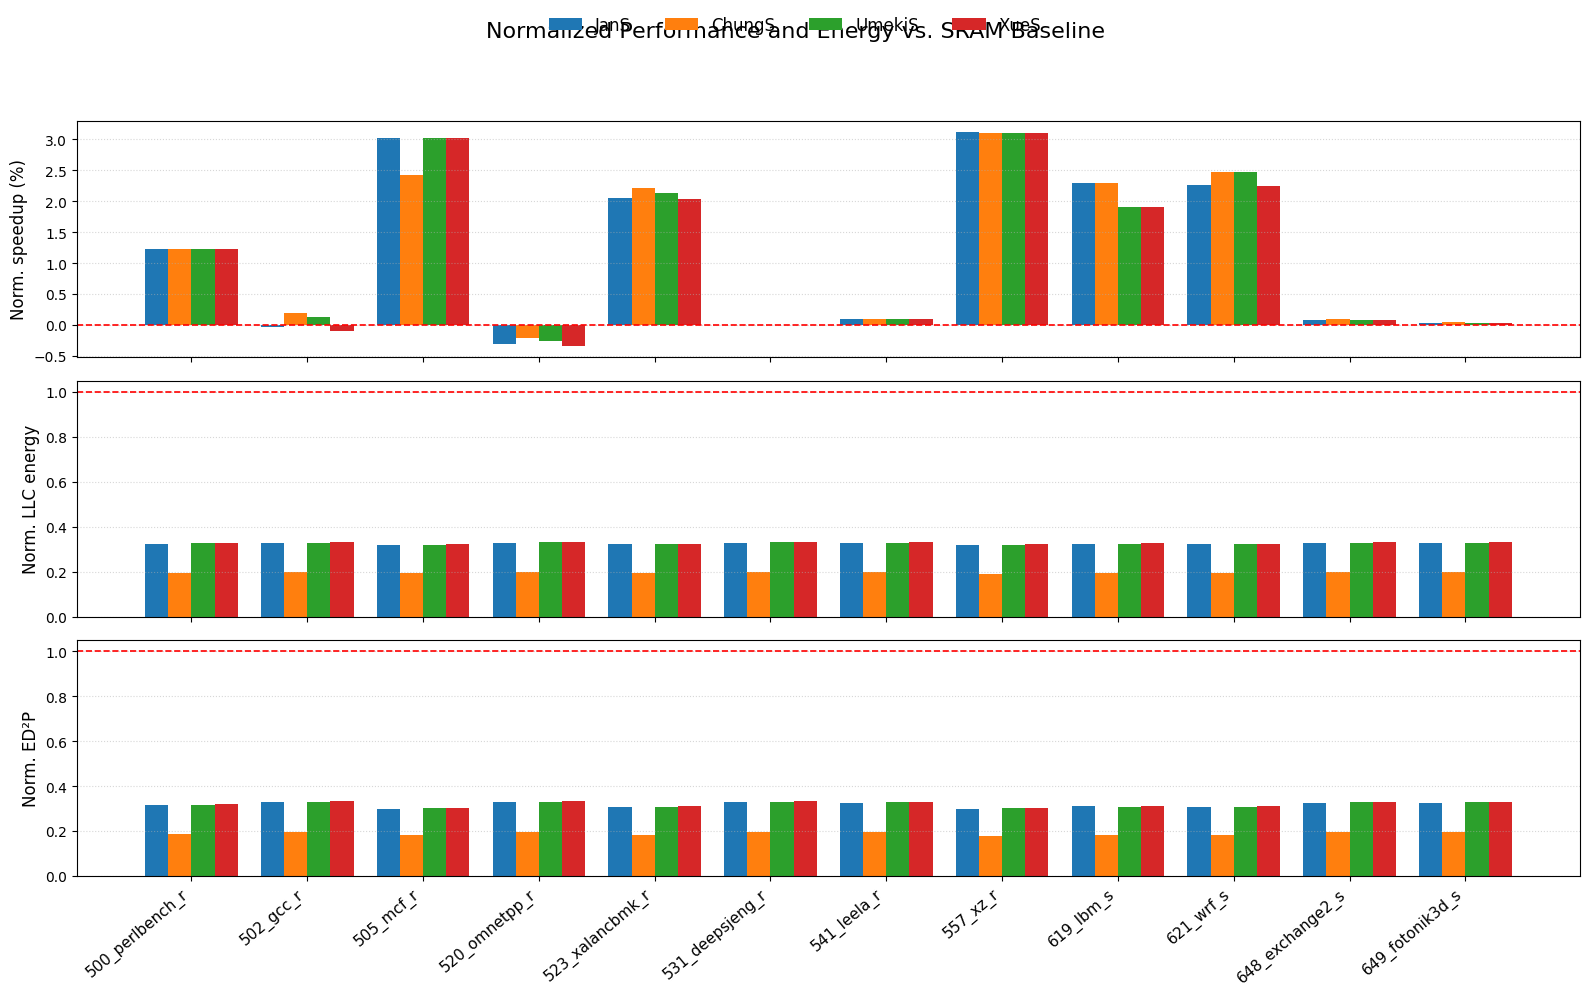


[INFO] Generating combined correlation heatmap...

--- Data sample for device: JanS ---
          benchmark  exe_time  LLC_energy
1   500_perlbench_r  0.000568    0.000643
5         502_gcc_r  0.003137    0.003562
9         505_mcf_r  0.000165    0.000187
13    520_omnetpp_r  0.034646    0.039152
17  523_xalancbmk_r  0.001172    0.001326

--- Data sample for device: ChungS ---
          benchmark  exe_time  LLC_energy
0   500_perlbench_r  0.000567    0.000385
4         502_gcc_r  0.003130    0.002136
8         505_mcf_r  0.000165    0.000112
12    520_omnetpp_r  0.034615    0.023466
16  523_xalancbmk_r  0.001171    0.000796

--- Data sample for device: UmekiS ---
          benchmark  exe_time  LLC_energy
2   500_perlbench_r  0.000567    0.000643
6         502_gcc_r  0.003132    0.003561
10        505_mcf_r  0.000165    0.000187
14    520_omnetpp_r  0.034630    0.039232
18  523_xalancbmk_r  0.001172    0.001329

--- Data sample for device: XueS ---
          benchmark  exe_time  LLC_en

/tmp/ipykernel_1875800/1866855153.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


[SAVED] /home/skataoka26/COSC_498/miniMXE/results/_viz_multi_cfg_final/corr_combined.png


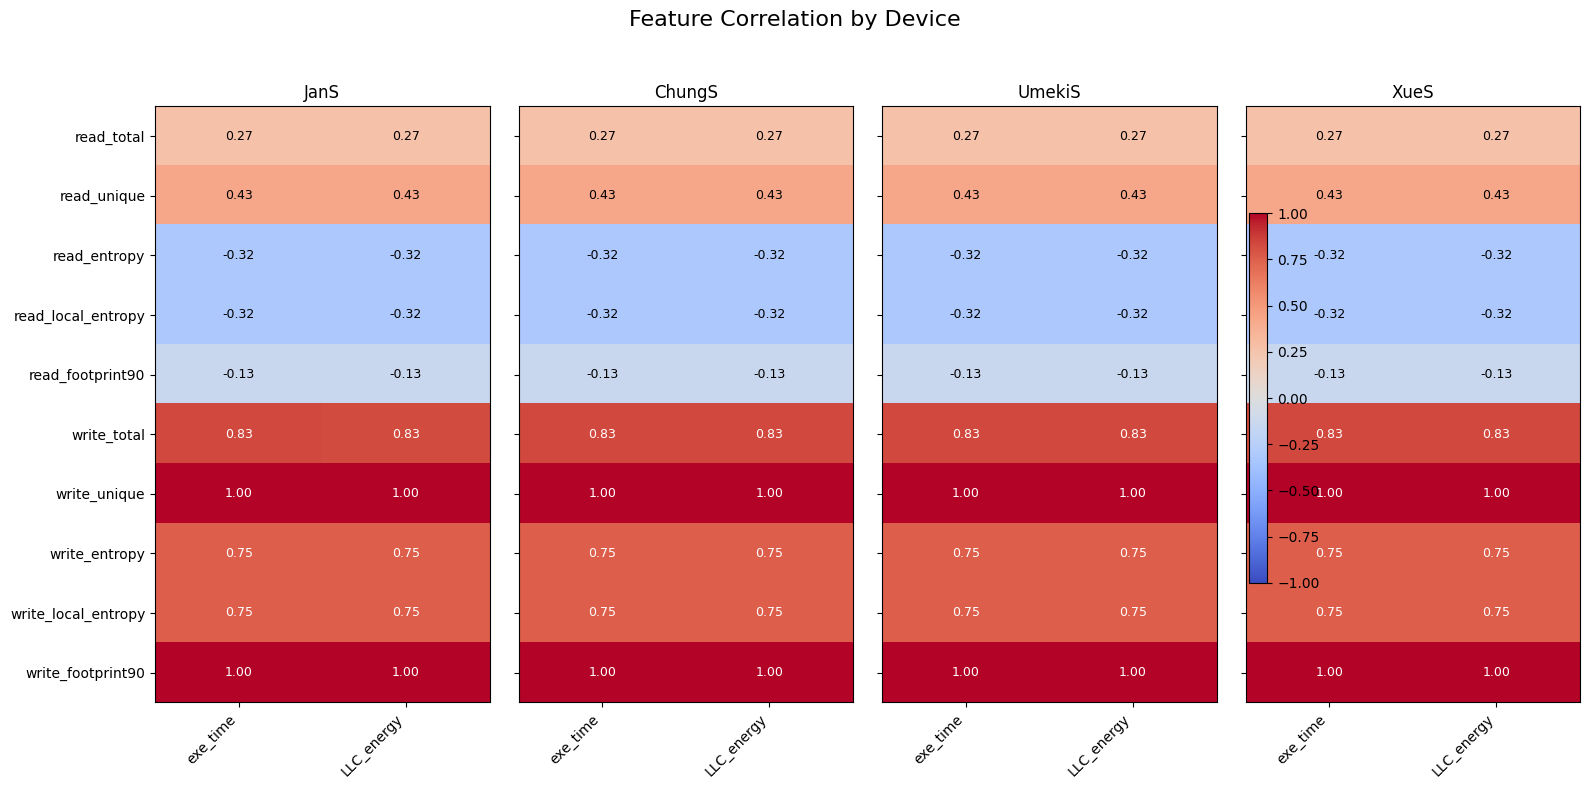

In [52]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FEATURES_CSV = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_test_20250922T224013Z.csv"

DEVICE_MAPPING = {
    "JanS":   "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_janS_custom_energy_20250922T051034Z",
    "ChungS": "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_chungS_custom_energy_20250922T051023Z",
    "UmekiS": "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_umekiS_custom_energy_20250922T051026Z",
    "XueS":   "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_xueS_custom_energy_20250922T051029Z",
}
DEVICES = list(DEVICE_MAPPING.keys())

BASELINE_CONFIG = "SRAM"

OUT_DIR = "/home/skataoka26/COSC_498/miniMXE/results/_viz_multi_cfg_final"
os.makedirs(OUT_DIR, exist_ok=True)

def read_all_energy_summaries(run_dirs):
    e_rows = []
    for rd in run_dirs:
        e_files = sorted(glob.glob(os.path.join(rd, "output_*", "energy_bounds.csv")))
        if not e_files:
            continue
        for f in e_files:
            try:
                df = pd.read_csv(f)
                df["run_dir"] = os.path.basename(rd)
                e_rows.append(df)
            except Exception as ex:
                print(f"[WARN] energy read failed {f}: {ex}")

    if not e_rows:
        return pd.DataFrame()

    dfE = pd.concat(e_rows, ignore_index=True)

    if 'benchmark' in dfE.columns:
        dfE['benchmark'] = dfE['benchmark'].str.replace('.', '_', regex=False)

    for c in ["time_s", "energy_exact_J", "ed2p_exact_J_s2"]:
        if c in dfE.columns:
            dfE[c] = pd.to_numeric(dfE[c], errors="coerce")
    return dfE

def tidy_unique_by_mean(dfE):
    keep = ["benchmark", "config", "device", "time_s", "energy_exact_J", "ed2p_exact_J_s2"]
    present = [c for c in keep if c in dfE.columns]
    g = dfE[present].groupby(["benchmark", "config", "device"], as_index=False).mean(numeric_only=True)
    return g

def plot_three_panel(speed_df, energy_df, ed2p_df, devices, title, outfile):
    fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
    ax1, ax2, ax3 = axes
    x = np.arange(len(speed_df.index))
    width = max(0.8 / max(1, len(devices)), 0.1)

    # Plot Speedup
    for i, dev in enumerate(devices):
        vals = speed_df[dev].values.astype(float)
        ax1.bar(x + (i - (len(devices) - 1) / 2) * width, vals, width, label=dev)
    ax1.axhline(0, linestyle='--', linewidth=1.2, color='r')
    ax1.grid(True, axis='y', alpha=0.5, linestyle=':')
    ax1.set_ylabel("Norm. speedup (%)", fontsize=12)
    ax1.tick_params(axis='y', labelsize=10)

    # Plot Energy and ED2P
    # I dont know why I said ED2P honestly but lets be harsh on MRAM
    for ax, data, label in [(ax2, energy_df, "Norm. LLC energy"), (ax3, ed2p_df, "Norm. ED²P")]:
        for i, dev in enumerate(devices):
            vals = data[dev].values.astype(float)
            ax.bar(x + (i - (len(devices) - 1) / 2) * width, vals, width, label=dev)
        ax.axhline(1.0, linestyle='--', linewidth=1.2, color='r')
                #ax.set_yscale('log')
        #ax.set_ylim(0, 0.025)
        ax.grid(True, which='major', axis='y', alpha=0.5, linestyle=':')
        ax.grid(True, which='minor', axis='y', alpha=0.2, linestyle=':')
        ax.set_ylabel(label, fontsize=12)
        ax.tick_params(axis='y', labelsize=10)

    ax3.set_xticks(x)
    ax3.set_xticklabels(speed_df.index, rotation=40, ha="right", fontsize=11)
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(devices), fontsize=12, frameon=False)
    
    fig.suptitle(title, fontsize=16, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(outfile, dpi=200, bbox_inches='tight')
    print(f"[SAVED] {outfile}")
    plt.show()

def plot_combined_correlation_heatmaps(df_in, feature_cols, target_labels, devices, title, outfile):
    num_devices = len(devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(4 * num_devices, 8), sharey=True)
    if num_devices == 1: # Ensure axes is always a list
        axes = [axes]

    print("\n[INFO] Generating combined correlation heatmap...")
    for ax, device in zip(axes, devices):
        # Filter the merged dataframe to get data ONLY for the current device (publication).
        device_df = df_in[df_in["device"] == device]
    
        print(f"\n--- Data sample for device: {device} ---")
        print(device_df[['benchmark'] + target_labels].head())        
        num_df = device_df[feature_cols + target_labels].apply(pd.to_numeric, errors="coerce").dropna()

        if num_df.empty or num_df.shape[0] < 2:
            ax.set_title(f"{device}\n(No Data)")
            ax.set_xticks([])
            continue
        corr = num_df.corr(method="pearson")
        C = corr.loc[feature_cols, target_labels].values
        
        im = ax.imshow(C, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
        
        ax.set_xticks(np.arange(len(target_labels)))
        ax.set_xticklabels(target_labels, rotation=45, ha="right")
        ax.set_title(device, fontsize=12)

        # Add correlation values as text on the heatmap cells
        for i in range(len(feature_cols)):
            for j in range(len(target_labels)):
                val = C[i, j]
                if not np.isnan(val):
                    text_color = "white" if abs(val) > 0.6 else "black"
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color=text_color)
    
    axes[0].set_yticks(np.arange(len(feature_cols)))
    axes[0].set_yticklabels(feature_cols)

    fig.suptitle(title, fontsize=16)
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(outfile, dpi=200, bbox_inches='tight')
    print(f"[SAVED] {outfile}")
    plt.show()

def main():
    all_dfE_rows = []
    
    print(f"[INFO] Loading data for {len(DEVICES)} devices.")
    for device_name, dir_path in DEVICE_MAPPING.items():
        print(f"  - Loading '{device_name}' from '{dir_path}'")
        dfE_device = read_all_energy_summaries([dir_path])
        if not dfE_device.empty:
            dfE_device['device'] = device_name
            dfE_device.loc[dfE_device['config'] != BASELINE_CONFIG, 'config'] = device_name
            all_dfE_rows.append(dfE_device)

    if not all_dfE_rows:
        raise SystemExit("No data loaded. Check DEVICE_MAPPING paths.")
    
    dfE_full = pd.concat(all_dfE_rows, ignore_index=True)
    dfE_unique = tidy_unique_by_mean(dfE_full)

    speedup_data, energy_data, ed2p_data = {}, {}, {}
    all_benchmarks = set()

    for device in DEVICES:
        target_config = device
        df_dev = dfE_unique[(dfE_unique['device'] == device) & (dfE_unique['config'].isin([BASELINE_CONFIG, target_config]))]
        
        if df_dev.empty: continue

        pivoted = df_dev.pivot_table(index='benchmark', columns='config', values=['time_s', 'energy_exact_J', 'ed2p_exact_J_s2'])
        
        if (('time_s', BASELINE_CONFIG) not in pivoted.columns) or \
           (('time_s', target_config) not in pivoted.columns):
            continue
            
        pivoted.dropna(inplace=True)
        all_benchmarks.update(pivoted.index)

        t_base = pivoted[('time_s', BASELINE_CONFIG)]
        e_base = pivoted[('energy_exact_J', BASELINE_CONFIG)]
        d_base = pivoted[('ed2p_exact_J_s2', BASELINE_CONFIG)]
        
        t_cfg = pivoted[('time_s', target_config)]
        e_cfg = pivoted[('energy_exact_J', target_config)]
        d_cfg = pivoted[('ed2p_exact_J_s2', target_config)]

        speedup_data[device] = (t_base / t_cfg - 1.0) * 100.0
        energy_data[device] = e_cfg / e_base
        ed2p_data[device] = d_cfg / d_base

    if not speedup_data or not all_benchmarks:
        print("\n[ERROR] No devices had complete data for the bar plot. Skipping plot generation.")
    else:
        devices_to_plot = list(speedup_data.keys())
        all_benchmarks_sorted = sorted(list(all_benchmarks))
        speedup_df = pd.DataFrame(speedup_data).reindex(all_benchmarks_sorted)
        energy_df = pd.DataFrame(energy_data).reindex(all_benchmarks_sorted)
        ed2p_df = pd.DataFrame(ed2p_data).reindex(all_benchmarks_sorted)
        
        plot_title = "Normalized Performance and Energy vs. SRAM Baseline"
        outfile_bar = os.path.join(OUT_DIR, "three_panel_by_device.png")
        plot_three_panel(speedup_df, energy_df, ed2p_df, devices_to_plot, plot_title, outfile_bar)
    try:
        feat = pd.read_csv(FEATURES_CSV)
        feat["bench"] = feat["name"].str.replace('.', '_', regex=False)
    except FileNotFoundError:
        raise SystemExit(f"ERROR: Features file not found at: {FEATURES_CSV}")

    feature_cols = [c for c in [
        "read_total", "read_unique", "read_entropy", "read_local_entropy", "read_footprint90",
        "write_total", "write_unique", "write_entropy", "write_local_entropy", "write_footprint90"
    ] if c in feat.columns]
    
    df_corr_base = dfE_unique[dfE_unique['config'].isin(DEVICES)]
    merged_df = df_corr_base.merge(feat[["bench"] + feature_cols], left_on="benchmark", right_on="bench", how="inner")

    targets = ["time_s", "energy_exact_J"]
    target_labels = ["exe_time", "LLC_energy"]
    merged_df.rename(columns=dict(zip(targets, target_labels)), inplace=True)

    # FIX: Call the new combined plotting function.
    corr_title = "Feature Correlation by Device"
    outfile_corr = os.path.join(OUT_DIR, "corr_combined.png")
    plot_combined_correlation_heatmaps(merged_df, feature_cols, target_labels, DEVICES, corr_title, outfile_corr)

if __name__ == "__main__":
    main()


=== 1) Evidence that gating was NOT modeled (leak_J ≈ leak_W * time_s) ===
SRAM: leak_J ≈ 3.438000 * time_s + -0.000000,  R^2=1.000000
   max |leak_J - leak_W*time_s| = 1.870000e-06 J
JanS: leak_J ≈ 0.048000 * time_s + 0.000000,  R^2=1.000000
   max |leak_J - leak_W*time_s| = 4.720000e-07 J


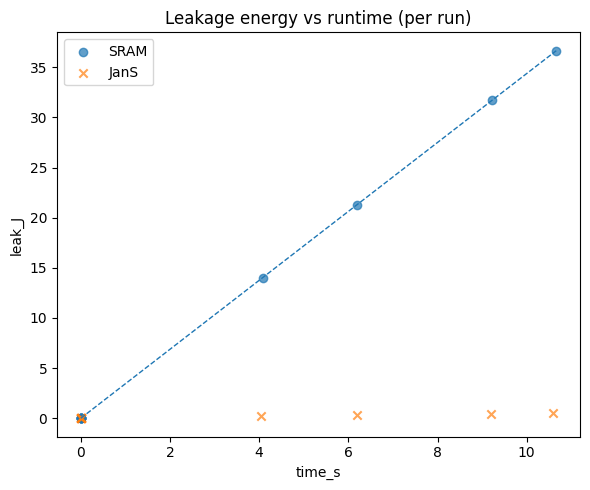


=== 2) Perf impact measurable from results ===
Median L3 hit-latency ratio (JanS / SRAM): 1.8556488513345428
Median runtime delta % (JanS vs SRAM): -1.5679442508710806

=== 3) Conservative bound on gating opportunity from access rates ===
SRAM (assuming 16 banks):
  median P_gap>0.1us per bank: 8.876e-01   median Exp# gaps>0.1us per run: 977.93
  median P_gap>1us per bank: 3.036e-01   median Exp# gaps>1us per run: 437.66
  median P_gap>10us per bank: 6.662e-06   median Exp# gaps>10us per run: 0.01
  median P_gap>100us per bank: 1.722e-52   median Exp# gaps>100us per run: 0.00
  median P_gap>1000us per bank: 0.000e+00   median Exp# gaps>1000us per run: 0.00
JanS (assuming 16 banks):
  median P_gap>0.1us per bank: 8.844e-01   median Exp# gaps>0.1us per run: 975.99
  median P_gap>1us per bank: 2.929e-01   median Exp# gaps>1us per run: 429.07
  median P_gap>10us per bank: 4.642e-06   median Exp# gaps>10us per run: 0.01
  median P_gap>100us per bank: 4.649e-54   median Exp# gaps>100us per 

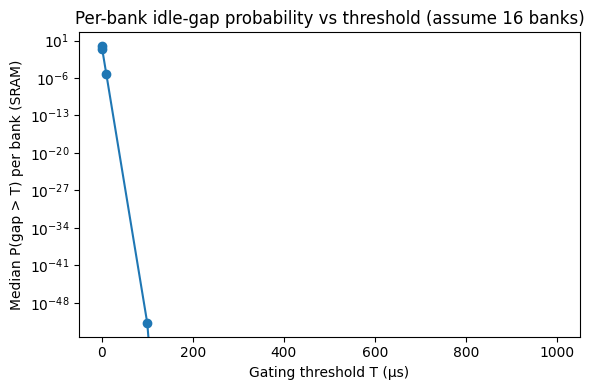

In [5]:
# ===========================
# Can we infer gating from results only?
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n=== 1) Evidence that gating was NOT modeled (leak_J ≈ leak_W * time_s) ===")
chk = dfE.copy()
for c in ["leak_W","leak_J","time_s"]:
    chk[c] = pd.to_numeric(chk[c], errors="coerce")
chk = chk.dropna(subset=["leak_W","leak_J","time_s"])

def leak_fit(df, cfg):
    s = df[df["config"]==cfg].copy()
    X = s["time_s"].to_numpy()
    y = s["leak_J"].to_numpy()
    if len(s) == 0:
        print(f"{cfg}: no rows")
        return
    m = (X@y) / (X@X)  # least squares slope with intercept forced near 0
    b = y.mean() - m*X.mean()
    r2 = 1 - np.sum((y - (m*X + b))**2) / np.sum((y - y.mean())**2)
    print(f"{cfg}: leak_J ≈ {m:.6f} * time_s + {b:.6f},  R^2={r2:.6f}")
    print(f"   max |leak_J - leak_W*time_s| = {np.max(np.abs(s['leak_J'] - s['leak_W']*s['time_s'])):.6e} J")

leak_fit(chk, "SRAM")
leak_fit(chk, "JanS")

# Optional visualization (one figure)
plt.figure(figsize=(6,5))
for cfg, marker in [("SRAM","o"), ("JanS","x")]:
    s = chk[chk["config"]==cfg]
    plt.scatter(s["time_s"], s["leak_J"], marker=marker, label=cfg, alpha=0.7)
plt.plot([chk["time_s"].min(), chk["time_s"].max()],
         [ (chk["leak_W"]*chk["time_s"]).min(), (chk["leak_W"]*chk["time_s"]).max() ],
         linestyle="--", linewidth=1)
plt.xlabel("time_s")
plt.ylabel("leak_J")
plt.title("Leakage energy vs runtime (per run)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== 2) Perf impact measurable from results ===")
print("Median L3 hit-latency ratio (JanS / SRAM):", float(df["hit_ns_ratio_JanS_over_SRAM"].median()))
print("Median runtime delta % (JanS vs SRAM):", float(df["time_delta_pct"].median()))
# (You already plot scatter of time_delta_pct vs hit-latency ratio elsewhere.)

print("\n=== 3) Conservative bound on gating opportunity from access rates ===")
# Assumptions: Even hashing across banks; arrivals ~ Poisson per bank.
# For bank arrival rate λ_bank, the probability a gap exceeds T is P(gap > T) = exp(-λ_bank * T).
# We show this probability and expected # of such gaps in a run (L*λ_bank*exp(-λ_bank*T)).

N_BANKS = 16                  # be generous to gating (larger -> more idle per bank)
THRESHOLDS_US = [0.1, 1, 10, 100, 1000]  # candidate gating thresholds (μs)

def gating_table(dfE, cfg, banks=N_BANKS, thresholds_us=THRESHOLDS_US):
    d = dfE[dfE["config"]==cfg].copy()
    d["rate_total"] = pd.to_numeric(d["l3_accesses"], errors="coerce") / pd.to_numeric(d["time_s"], errors="coerce")
    d = d.dropna(subset=["rate_total","time_s"])
    d["rate_bank"] = d["rate_total"] / float(banks)
    rows = []
    for _, row in d.iterrows():
        lam = max(row["rate_bank"], 1e-12)     # /s
        L   = row["time_s"]                    # s
        rec = {"benchmark": row["benchmark"], "lambda_bank_per_s": lam, "time_s": L}
        for T in thresholds_us:
            T_s = T*1e-6
            p_gap = float(np.exp(-lam*T_s))
            exp_cnt = float(L * lam * p_gap)   # expected # gaps > T in the run
            rec[f"P_gap>{T}us"] = p_gap
            rec[f"Exp#_gaps>{T}us"] = exp_cnt
        rows.append(rec)
    return pd.DataFrame(rows)

G_sram = gating_table(dfE, "SRAM")
G_jans = gating_table(dfE, "JanS")

def print_summary(G, label):
    if G.empty:
        print(f"{label}: no rows")
        return
    meds = {c: float(G[c].median()) for c in G.columns if c not in ["benchmark"]}
    print(f"{label} (assuming {N_BANKS} banks):")
    for T in THRESHOLDS_US:
        print(f"  median P_gap>{T}us per bank: {meds[f'P_gap>{T}us']:.3e}   "
              f"median Exp# gaps>{T}us per run: {meds[f'Exp#_gaps>{T}us']:.2f}")

print_summary(G_sram, "SRAM")
print_summary(G_jans, "JanS")

# One compact plot: median P(gap > T) vs T for SRAM
if not G_sram.empty:
    T = np.array(THRESHOLDS_US, dtype=float)
    lam_med = float(G_sram["lambda_bank_per_s"].median())
    plt.figure(figsize=(6,4))
    plt.semilogy(T, np.exp(-lam_med*T*1e-6), marker="o")
    plt.xlabel("Gating threshold T (μs)")
    plt.ylabel("Median P(gap > T) per bank (SRAM)")
    plt.title(f"Per-bank idle-gap probability vs threshold (assume {N_BANKS} banks)")
    plt.tight_layout()
    plt.show()
